In [1]:
nro = 18639429
# Sets a random seed for replicable values
import tensorflow as tf
import numpy as np
import random

random.seed(nro)
np.random.seed(nro)
tf.random.set_seed(nro)

# Actividad 1

Tal como se mencionó en cápsulas, las Redes Neuronales Convolucionales son redes que en sus capas convolucionales realizan operaciones llamadas convoluciones sobre las imágenes, aplicando diversas transformaciones para obtener información del contenido de la imagen. 

Su ventaja respecto a las redes convencionales es principalmente la capacidad de recuperar información en base a áreas de la imagen y su contenido como conjunto, relacionando un píxel con su entorno, no así como una red normal que le da valor a cada píxel por sí solo, impidiendo entender el contenido completo.

# Actividad 2

Definimos la función a continuación:

In [2]:
def simple_2d_convolution(img, kernel):    
    # Copiamos el arreglo que contendrá la nueva imagen
    new_img = img.copy()
    
    # Vamos proyectando el kernel a través de los píxeles de la imagen
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            
            # Obtenemos la submatriz de píxeles que se van a convolucionar
            pixels = np.array([
                [img[i - 1, j - 1], img[i - 1, j], img[i - 1, j + 1]],
                [img[i, j - 1],     img[i, j],     img[i, j + 1]],
                [img[i + 1, j - 1], img[i + 1, j], img[i + 1, j + 1]]
            ])
            
            # Realiza la convolución
            convoluted_value = np.sum(pixels * kernel)
            
            # Se actualiza el valor del píxel
            new_img[i, j] = convoluted_value
    return new_img

Definimos los kernels a utilizar:

In [3]:
# Kernels

k1 = np.array([
    [-1, -1, -1], 
    [-1,  8, -1], 
    [-1, -1, -1]
])

k2 = np.array([
    [1,  0, -1], 
    [0,  0,  0], 
    [-1, 0,  1]
])

k3 = np.array([
    [0, 1, 0], 
    [1, -4, 1], 
    [0, 1, 0]
])

kernel_list = [k1, k2, k3]

Probamos la función:

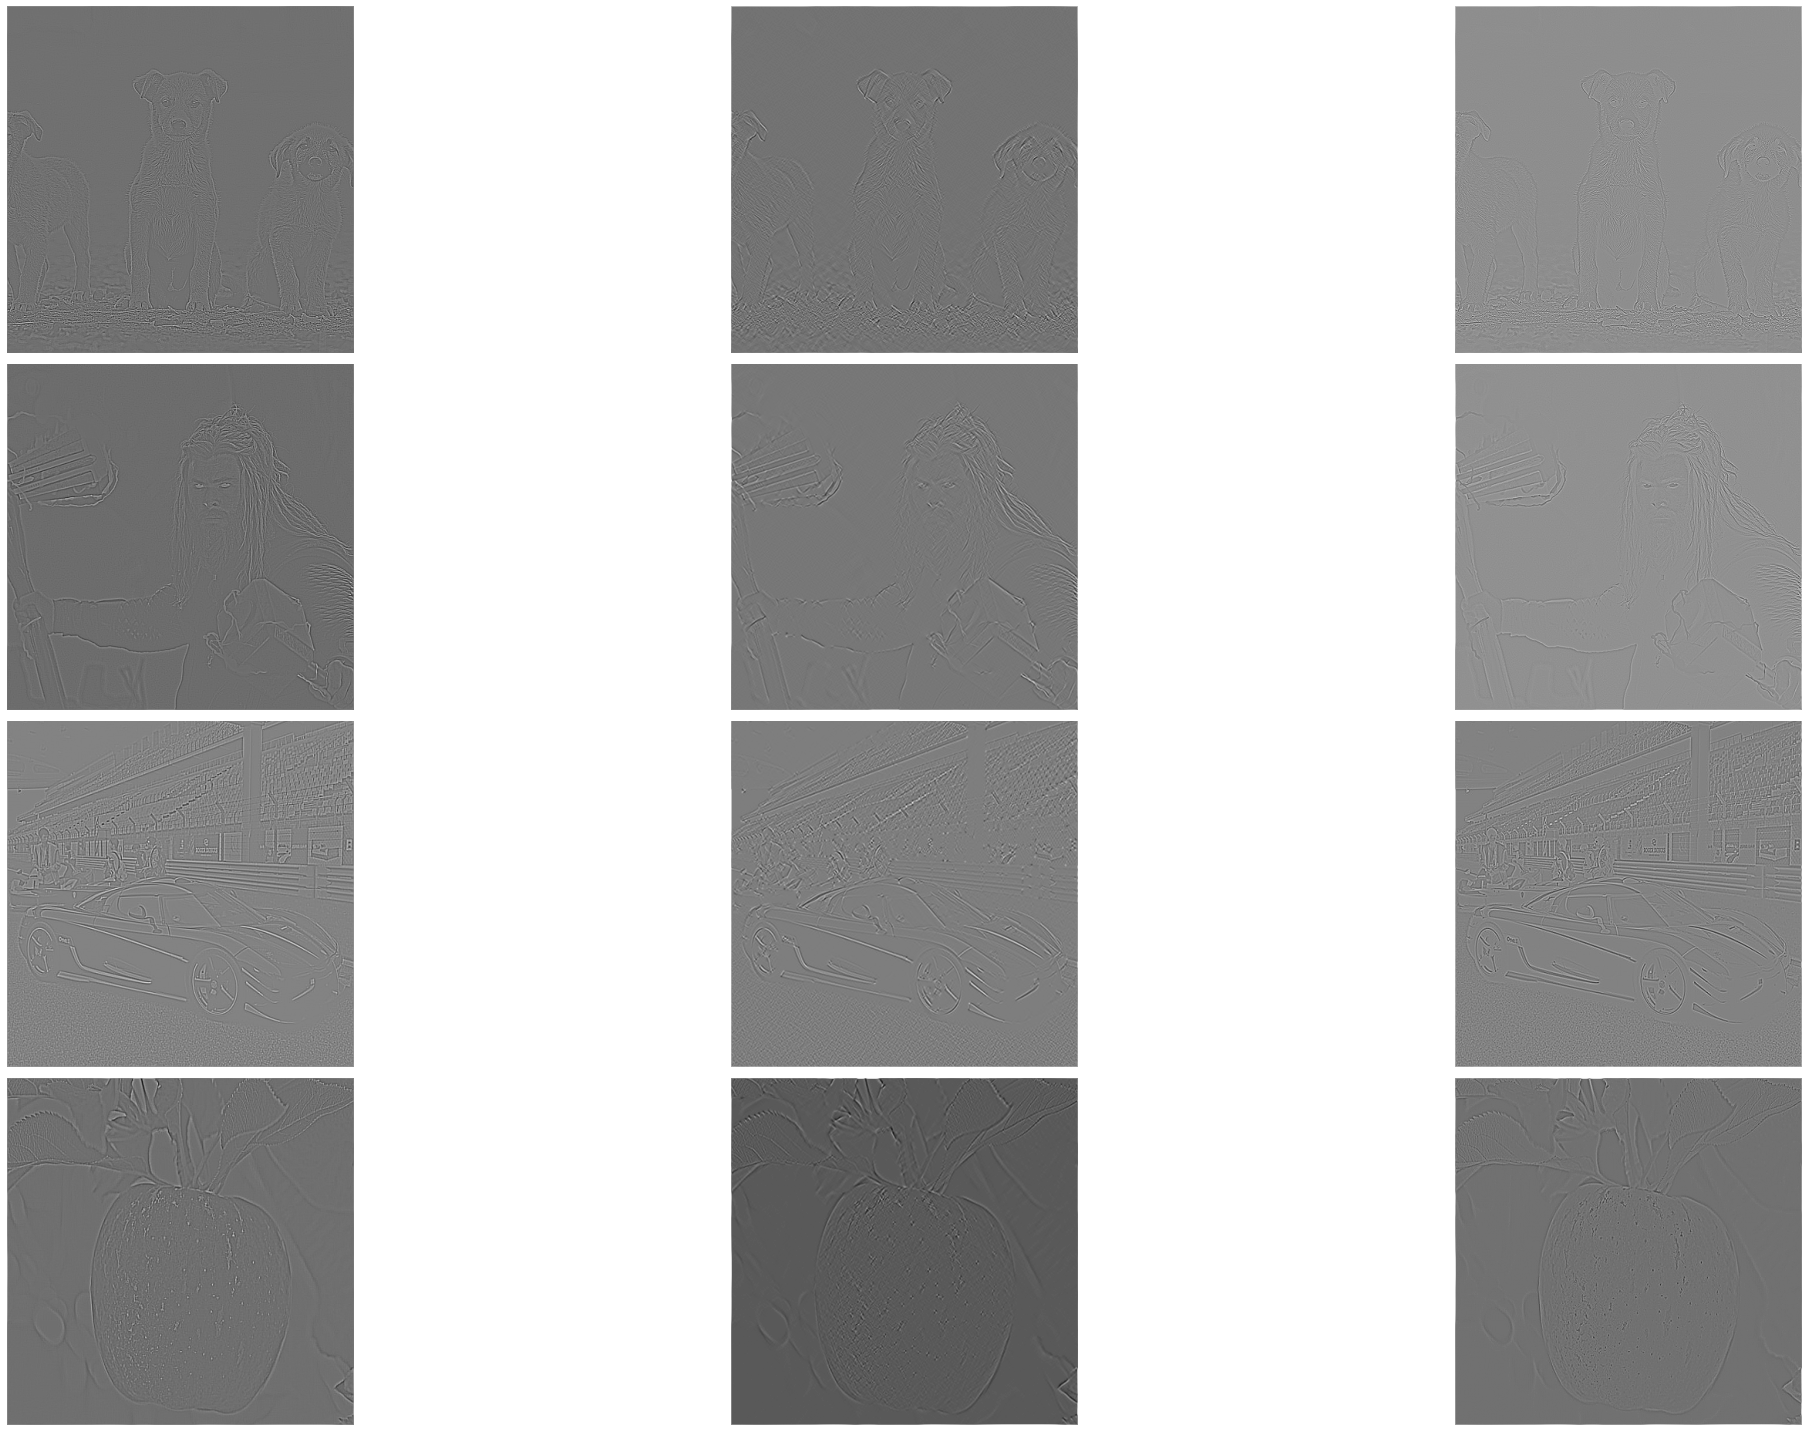

In [33]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(35, 20))

for i in range(4):
    # Cargamos la imagen
    img = cv2.imread(f"./convolution_tests/{i + 1}.jpg")
    
    # Reajustamos el tamaño de la imagen y la cambiamos a escala de grises
    img = cv2.resize(img, (450, 450))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.reshape(450, 450)
    
    # Estandarizamos
    img = img / 255
    
    for index, kernel in enumerate(kernel_list):
        plt.subplot(4, 3, index + 1 + i * 3)
        plt.imshow(simple_2d_convolution(img, kernel), cmap="gray")
        plt.axis("off")
    
plt.tight_layout()
plt.show()

# Actividad 3

Importamos el *dataset* desde TensorFlow.

In [5]:
import tensorflow as tf
import tensorflow_datasets as tf_datasets

data, info = tf_datasets.load("malaria", as_supervised=True, with_info=True)

Mostramos algunas imágenes del *dataset*:

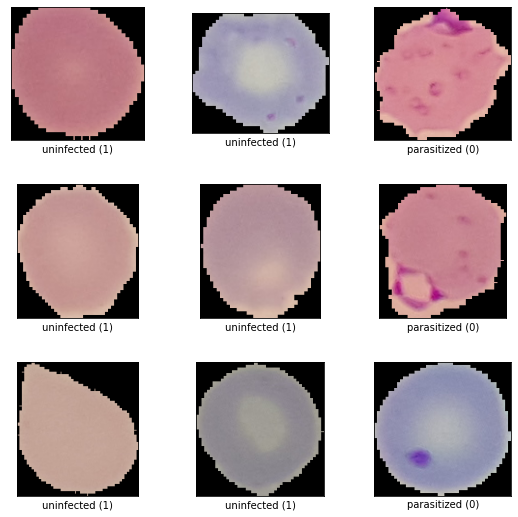

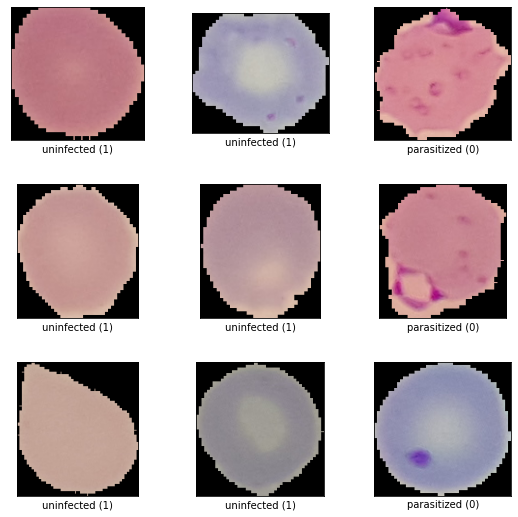

In [6]:
tf_datasets.show_examples(data["train"], info)

Rápidamente, podemos notar algunas cosas interesantes de las imágenes:
* Hay imágenes de distintos tamaños
* Hay imágenes de distintos colores
* Las imágenes que corresponden a célular infectadas parecen tener una especie de bola o círculo de tonalidad más concentrada

Vemos que en el caso de las células infectadas suele apreciarse una mancha oscura, probablemente asociada al parásito, mientras que en las demás células parece estar ausente esta característica. Dicho esto, no parece ser que el color sea significativo, ya que a simple vista es fácil reconocer esta mancha, pues está asociada a una saturación mayor y no a algún color particular.

# Actividad 4

Dado lo analizado anteriormente, parece razonable primero reajustar los tamaños para que todos tengan el mismo y así poder pasarlos a la red, y luego pasarlas a escala de grises:

In [7]:
def img_pre_processing(original_img, width, height):
    pre_processed_img = cv2.resize(original_img.numpy(), (width, height))
    pre_processed_img = cv2.cvtColor(pre_processed_img, cv2.COLOR_BGR2GRAY)
    pre_processed_img = pre_processed_img.reshape(width, height, 1)
    return pre_processed_img

Podemos ver un ejemplo de como este cambio se refleja en la imagen número 3 de la primera fila que se vio en el conjunto de imágenes anteriores:

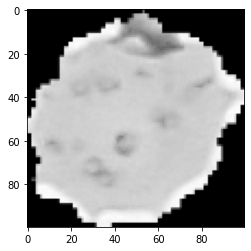

In [8]:
for _, (img, label) in enumerate(data["train"].take(3)):
    pre_processed_img_to_plot = img_pre_processing(img, 100, 100).reshape(100, 100)
    plt.imshow(pre_processed_img_to_plot, cmap="gray")

Notamos que la información aún es clara y se mantienen esas tonalidades más oscuras al interior de las células infectadas. Ahora, guardamos las *features* en `X` y las *labels* en `y`:

In [9]:
import pandas as pd

X = []
y = []

for _, (img, label) in enumerate(data["train"]):
    X.append(img_pre_processing(img, 100, 100))
    y.append(int(label))

Podemos mostrar nuevamente las primeras 9 imágenes y ver cómo se diferencian en comparación a las originales:

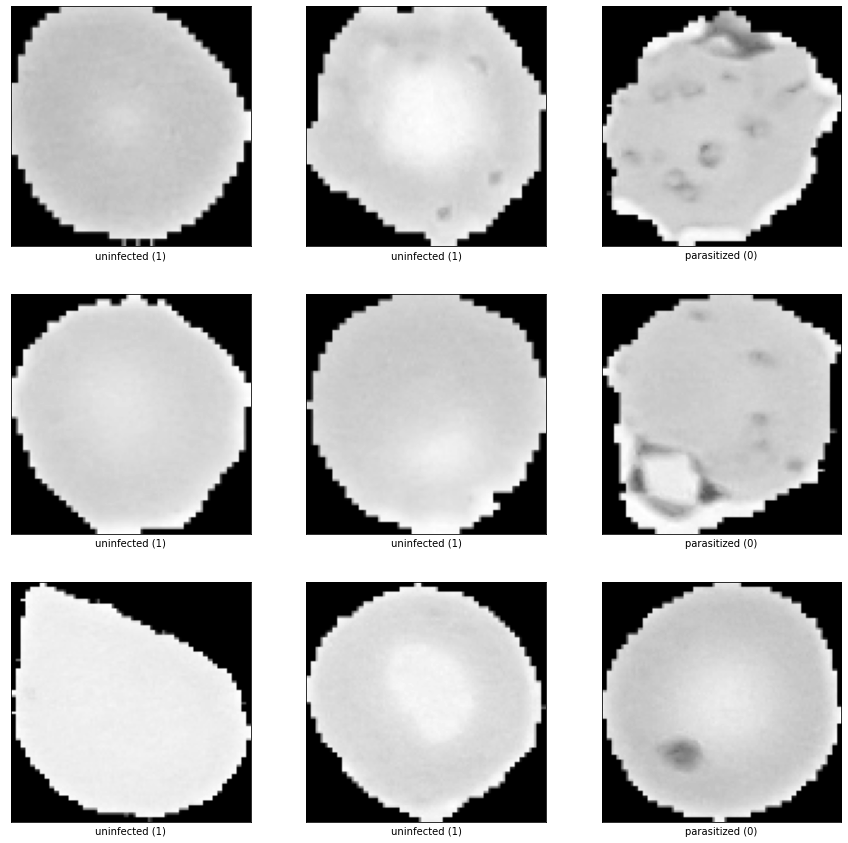

In [10]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(X[i].reshape(100, 100), cmap="gray")
    if y[i] == 0:
        plt.xlabel("parasitized (0)")
    else:
        plt.xlabel("uninfected (1)")
plt.show()

La misma documentación de TensorFlow nos dice de antemano que las instancias por clase están balanceadas, pero podemos comprobarlo a continuación:

In [11]:
import numpy as np

y = np.array(y)
print("Instancias por categoría")
unique, counts = np.unique(y, return_counts=True)
for label, freq in np.asarray((unique, counts)).T:
    print(f" - {label}: {freq} instancias")

Instancias por categoría
 - 0: 13779 instancias
 - 1: 13779 instancias


Para dar los valores de los píxeles de nuestra imagen a la red neuronal y que esta funcione mejor, debemos estandarizarlos con estandarización min-max. En esta, cada valor estandarizado tiene el siguiente valor:

$$\frac{valor - min}{max - min}$$

donde `valor` es el valor que estamos estandarizando y `min` y `max` son los valores mínimo y máximos de entre todos los datos, respectivamente.

En este caso, hay muchas formas de hacerlo, podemos usar esa función sobre la columna usando Pandas, podemos usar funciones de otras librerías, pero la más sencilla es simplemente dividir cada dato por 255. Esto se debe a que se trata de píxeles, donde el mínimo valor posible que pueden tomar es 0 y el máximo es 255:

In [12]:
X = np.array(X).astype(float) / 255

Ahora dividimos el set de datos en train y test. Como tenemos bastantes datos, utilizaremos un 70% para entrenamiento y un 30% para test:

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=nro)

Mostramos cuántas instancias quedaron por set:

In [14]:
print("\n>> Set de entrenamiento (instancias por categoría)")
unique, counts = np.unique(y_train, return_counts=True)
for label, freq in np.asarray((unique, counts)).T:
  print(f" - {label}: {freq} instancias")

print("\n>> Set de test (instancias por categoría)")
unique, counts = np.unique(y_test, return_counts=True)
for label, freq in np.asarray((unique, counts)).T:
  print(f" - {label}: {freq} instancias")


>> Set de entrenamiento (instancias por categoría)
 - 0: 9683 instancias
 - 1: 9607 instancias

>> Set de test (instancias por categoría)
 - 0: 4096 instancias
 - 1: 4172 instancias


Vemos que las instancias por categoría y por test están bastante bien balanceadas, así que es un buen punto de partida para poder trabajar.

# Actividad 5

Podemos generar un modelo que compile sin usar aumento de datos ni *dropout*; y veremos su rendimiento. En este caso, usaremos una red que tenga 3 capas convolucionales, donde a cada una de ellas le sigue una de *pooling*. Luego, tendremos una capa plana para recibir los resultados y 2 capas densas para entregar el *output*:

---



In [15]:
model_1 = tf.keras.models.Sequential([
  # Capas convolucionales
  tf.keras.layers.Conv2D(30, (3, 3), activation="relu", input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(70, (3, 3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2, 2),

  # Capas densas
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

Como se ve en el caso anterior, la capa de entrada tiene dimensiones (100, 100, 1), que realmente es 100x100x1 = 1000 neuronas, pero la sintáxis indica cómo vienen agrupadas las imágenes, con dimensiones 100x100 y 1 solo canal de color. Podrían haber implementaciones alternativas, aunque habría que analizar el caso a caso.

Otra cosa a tener en cuenta, es que estamos usando 1 sola neurona en la capa de salida. Esto se debe a que estamos usando la función de activación `sigmoid` en la capa de salida y manejaremos la decisión en base al valor del *output*, diciendo que, por ejemplo, si esta entre 0 y 0.5 pertenece a una clase y si no, en la otra. Esto tiene sentido porque estamos trabajando con clasificación binaria. Si fueran más categorías no sería válido.

Este modeo (y los otros) ocuparán optimización "Adam" y como función de pérdida, usaremos `binary_crossentropy`, puesto que esta es especialmente buena en clasificación binaria. Como se trata de un contexto sanitario, donde queremos asegurarnos de diagnosticar a alguien, aunque no estemos 100% seguro, pero sin correr el riesgo de decirle que está sano a alguien que está infectado, maximizaremos la métrica *recall*:

In [16]:
model_1.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

Entrenaremos el modelo y para ver su evolución, ocuparemos la *dashboard* de TensorFlow:

In [17]:
from tensorflow.keras.callbacks import TensorBoard

También está bien balanceado en test, por lo que ahora podemos entrenar el modelo, guardando también una TensorBoard para ver su desempeño en el tiempo:

In [18]:
model_1_board = TensorBoard(log_dir="boards/modelo_1")

# Entrenamos con 15 épocas para hacernos una idea
history = model_1.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=25, callbacks=[model_1_board])

Epoch 1/25
483/483 [==============================] - 24s 32ms/step - loss: 0.6602 - accuracy: 0.6035 - val_loss: 0.6311 - val_accuracy: 0.6490
Epoch 2/25
483/483 [==============================] - 15s 31ms/step - loss: 0.5548 - accuracy: 0.7138 - val_loss: 0.4604 - val_accuracy: 0.7836
Epoch 3/25
483/483 [==============================] - 15s 31ms/step - loss: 0.3076 - accuracy: 0.8725 - val_loss: 0.2017 - val_accuracy: 0.9241
Epoch 4/25
483/483 [==============================] - 15s 31ms/step - loss: 0.1696 - accuracy: 0.9375 - val_loss: 0.1985 - val_accuracy: 0.9220
Epoch 5/25
483/483 [==============================] - 15s 31ms/step - loss: 0.1215 - accuracy: 0.9568 - val_loss: 0.1890 - val_accuracy: 0.9287
Epoch 6/25
483/483 [==============================] - 15s 31ms/step - loss: 0.0906 - accuracy: 0.9701 - val_loss: 0.2006 - val_accuracy: 0.9336
Epoch 7/25
483/483 [==============================] - 15s 31ms/step - loss: 0.0444 - accuracy: 0.9866 - val_loss: 0.2268 - val_accuracy:

Graficamos la evolución por las épocas del entrenamiento:

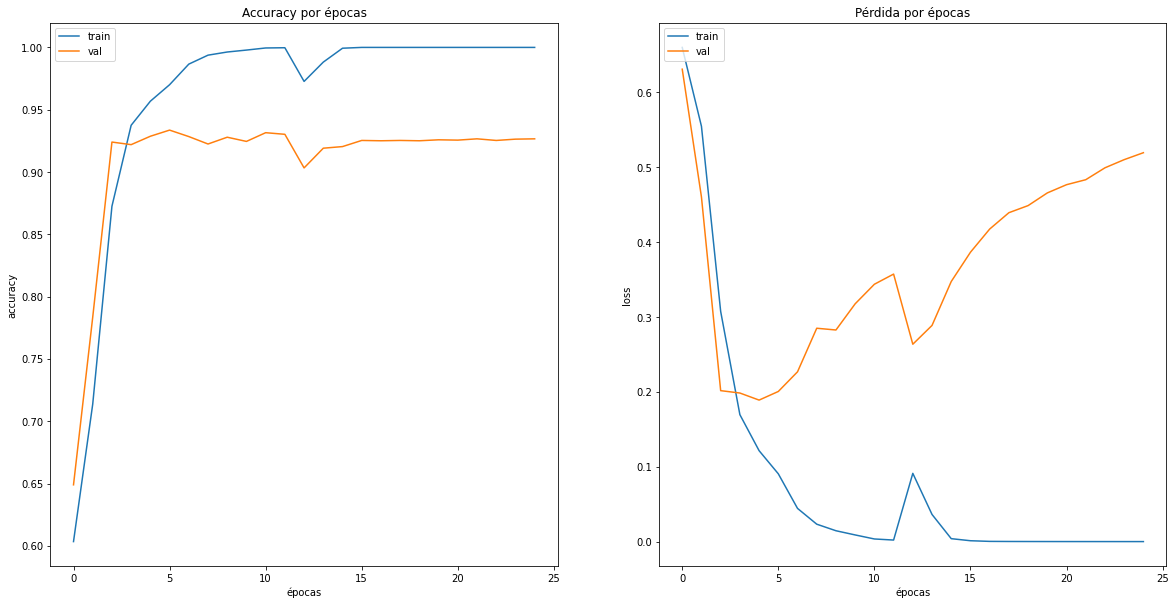

In [19]:
plt.figure(figsize=(20, 10))

# Graficamos la evolución del accuracy
plt.subplot(1, 2, 1)
plt.title('Accuracy por épocas')
plt.ylabel('accuracy')
plt.xlabel('épocas')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')

# Graficamos la evolución de la función de pérdida
plt.subplot(1, 2, 2)
plt.title('Pérdida por épocas')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Vemos que el *accuracy* aumenta en ambos sets con las épocas, aunque en un momento se empieza a estancar. Para el caso de la función de pérdida, al inicio en ambos set disminuye, pero a partir de la quinta época aprox. se dispara en el set de validación. Por otra parte, vemos que en *train* llega a un *accuracy* prácticamente del 100%, por lo que considerando también la información anterior podríamos decir que hay *overfitting*.

Comprobamos esto evaluando en el set de test:

In [20]:
performance = model_1.evaluate(X_test, y_test)
print(performance)

259/259 [==============================] - 3s 12ms/step - loss: 0.5480 - accuracy: 0.9278
[0.5480331778526306, 0.9277939200401306]


Logramos un 92-93% de *accuracy*, lo cual es bastante bueno, aunque con el riesgo de que no sea tan generalizable dado lo visto al entrenar.

# Actividad 6

El *dropout* es una técnica que básicamente busca reducir el *overfitting* del modelo a través de la desactivación aleatoria de neuronas de la red en las épocas durante el entrenamiento. La gracia de esto es que permite que no se carguen excesivamente los pesos de algunas conexiones, permitiendo que todas las neuronas puedan ajustarse a los datos, sin que alguna en particular se "lleve todo el protagonismo".

Creamos un nuevo modelo, con un *dropout* después de las capas convolucionales:

In [21]:
model_2 = tf.keras.models.Sequential([
  # Capas convolucionales
  tf.keras.layers.Conv2D(30, (3, 3), activation="relu", input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(70, (3, 3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2, 2),

  # Dropout con 0.5 de probabilidad
  tf.keras.layers.Dropout(0.5),

  # Capas densas
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

model_2_board = TensorBoard(log_dir="boards/modelo_2")

# Entrenamos con 15 épocas para hacernos una idea
history = model_2.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=25, callbacks=[model_2_board])

Epoch 1/25
483/483 [==============================] - 16s 33ms/step - loss: 0.6486 - accuracy: 0.6118 - val_loss: 0.5900 - val_accuracy: 0.6887
Epoch 2/25
483/483 [==============================] - 15s 32ms/step - loss: 0.4717 - accuracy: 0.7752 - val_loss: 0.2682 - val_accuracy: 0.9186
Epoch 3/25
483/483 [==============================] - 15s 32ms/step - loss: 0.2377 - accuracy: 0.9139 - val_loss: 0.1979 - val_accuracy: 0.9238
Epoch 4/25
483/483 [==============================] - 15s 32ms/step - loss: 0.2575 - accuracy: 0.8998 - val_loss: 0.1667 - val_accuracy: 0.9422
Epoch 5/25
483/483 [==============================] - 15s 31ms/step - loss: 0.1665 - accuracy: 0.9410 - val_loss: 0.1600 - val_accuracy: 0.9445
Epoch 6/25
483/483 [==============================] - 15s 31ms/step - loss: 0.1500 - accuracy: 0.9475 - val_loss: 0.1573 - val_accuracy: 0.9443
Epoch 7/25
483/483 [==============================] - 15s 31ms/step - loss: 0.1320 - accuracy: 0.9535 - val_loss: 0.1645 - val_accuracy:

Podemos graficar la evolución del modelo por época:

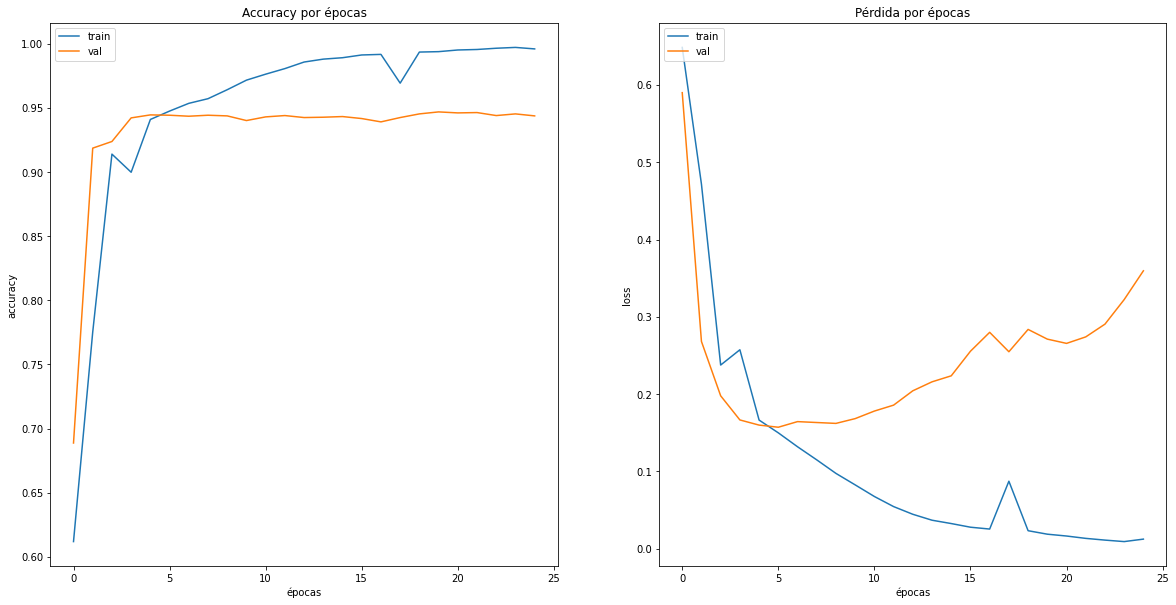

In [22]:
plt.figure(figsize=(20, 10))

# Graficamos la evolución del accuracy
plt.subplot(1, 2, 1)
plt.title('Accuracy por épocas')
plt.ylabel('accuracy')
plt.xlabel('épocas')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')

# Graficamos la evolución de la función de pérdida
plt.subplot(1, 2, 2)
plt.title('Pérdida por épocas')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

En este nuevo gráfico podemos notar dos cosas:
* El comportamiento del *accuracy* es más similar en train y validación
* Si bien a partir de cierto punto la función de pérdida en validación empieza a crecer, es más adelante en el entrenamiento y crece a un menor ritmo

Por lo tanto, podríamos decir que se trata de un mejor modelo. Por último, lo probamos en test:

In [23]:
performance = model_2.evaluate(X_test, y_test)
print(performance)

259/259 [==============================] - 3s 11ms/step - loss: 0.3716 - accuracy: 0.9405
[0.3716338574886322, 0.9404934644699097]


Vemos que se obtiene un resultado ligeramente mejor, con mayor *accuracy* y menor pérdida que en el primer modelo.

# Actividad 7

El aumento de datos es una técnica que nos permite enriquecer nuestro set de datos aplicando transformaciones a los datos originales. En el caso de las imágenes, nos permite crear variaciones de las imágenes con, por ejemplo, rotaciones, efectos espejos, zoom's, etc. La gracia de esto es que así nuestros datos tienen mayor diversidad, siendo más generalizables.

Un ejemplo sencillo de esto es que si queremos reconocer entre perros y gatos, para nosotros es fácil saberlo si le hacemos una rotación a la imagen o le hacemos un pequeño zoom.

En este caso, algunas transformaciones sencillas que nos pueden permitir enriquecer los datos son los *flips* (invertir las imágenes horizontalmente/verticalmente), hacer una rotación o hacer un pequeño zoom, ya que son transformaciones que no dificultan el reconocer la mancha del parásito y a la vez nos dan más variaciones de la imagen (hay otras opciones posibles también).

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aumented_data_generator = ImageDataGenerator(
    # Invertir imágenes
    vertical_flip=True,
    horizontal_flip=True,
    # Rotaciones (ángulo)
    rotation_range=100,
    # Zoom
    zoom_range=[0.7, 1.4]
)

A continuación, guardamos en la variable `aumented_data` instancias del set de entrenamiento, pero aplicando el aumento de datos. Al poner `batch_size=32` estamos agrupando las imagenes en lotes de 32.

In [25]:
aumented_data = aumented_data_generator.flow(X_train, y_train, batch_size=32, shuffle=False)

Podemos hacer esto y graficar algunas imágenes luego de la transformación:

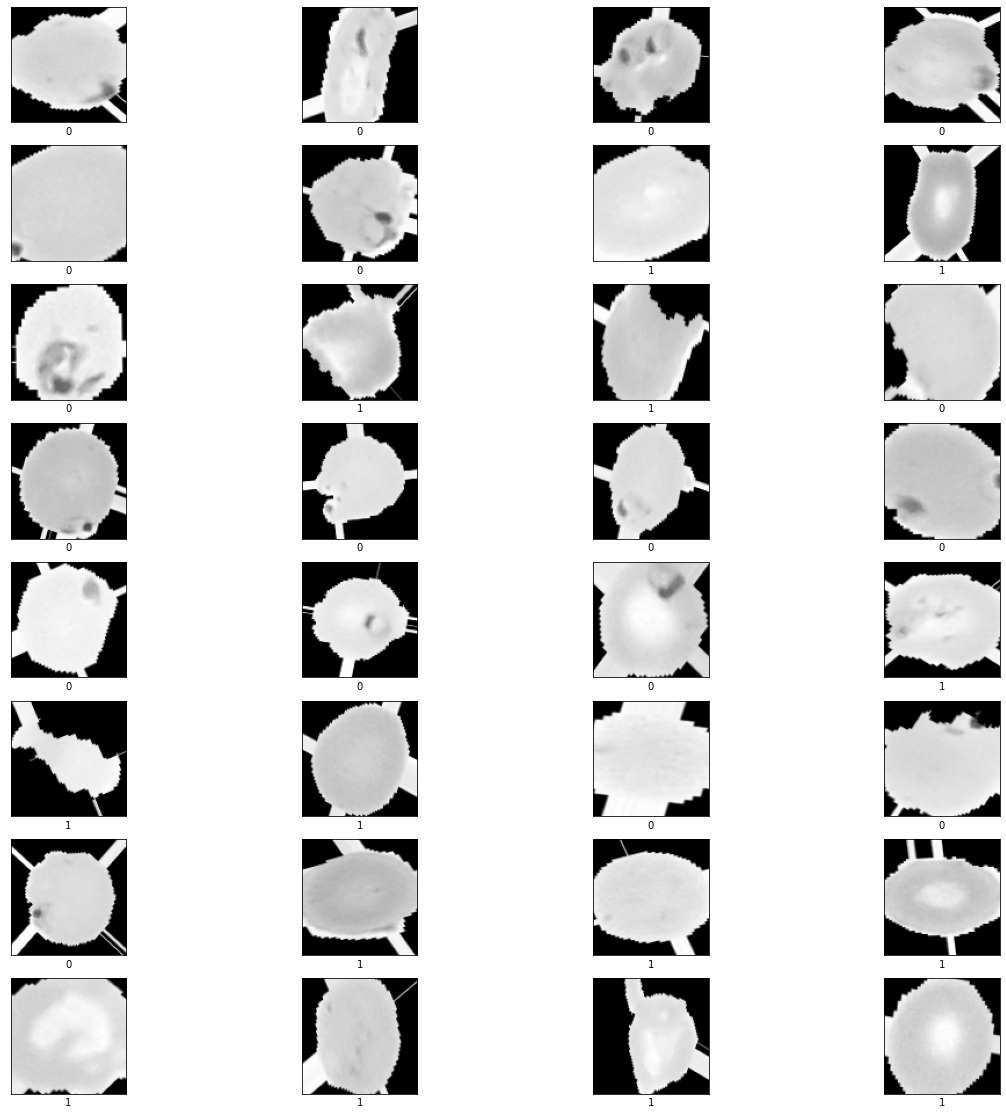

In [26]:
plt.figure(figsize=(20, 20))

for img_batch, label_batch in aumented_data:
  for i in range(32):
    plt.subplot(8, 4, i + 1)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img_batch[i].reshape(100, 100), cmap="gray")
    plt.xlabel(label_batch[i])
  break

plt.show()

Generamos un tercer modelo, el cuál  ocupará el set con aumento de datos. Sin embargo, el parámetro `validation_split` que teníamos antes es solo útil con arreglos de NumPy, por lo que deberemos hacer la separación en train y validación "a mano". Primero vemos cuántos datos tenemos:

In [27]:
print(X_train.shape)
at_80 = int(X_train.shape[0] * 0.8)
print(f"80%: {at_80}")

(19290, 100, 100, 1)
80%: 15432


Dejaremos el 80% para train y el otro 20% para validación:

In [28]:
X_train_aumented = aumented_data_generator.flow(X_train[:at_80], 
                                                y_train[:at_80], 
                                                batch_size=32, shuffle=False)

Ahora, entrenamos el modelo:

In [29]:
model_3 = tf.keras.models.Sequential([
  # Capas convolucionales
  tf.keras.layers.Conv2D(30, (3, 3), activation="relu", input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(70, (3, 3), activation="relu"),
  tf.keras.layers.MaxPooling2D(2, 2),

  # Dropout
  tf.keras.layers.Dropout(0.5),

  # Capas densas
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

model_3_board = TensorBoard(log_dir="boards/modelo_3")

# Entrenamos con 20 épocas para hacernos una idea y con el set aumentado
history = model_3.fit(aumented_data, batch_size=32, epochs=25, callbacks=[model_3_board],
            validation_data=(X_train[:at_80], y_train[:at_80]),
            steps_per_epoch=int(np.ceil(len(X_train[:at_80]) / float(32))),
            validation_steps=int(np.ceil(len(X_train[at_80:]) / float(32)))
            )

Epoch 1/25
483/483 [==============================] - 25s 50ms/step - loss: 0.6917 - accuracy: 0.5303 - val_loss: 0.6799 - val_accuracy: 0.6188
Epoch 2/25
483/483 [==============================] - 23s 49ms/step - loss: 0.6514 - accuracy: 0.6226 - val_loss: 0.5921 - val_accuracy: 0.6805
Epoch 3/25
483/483 [==============================] - 23s 48ms/step - loss: 0.4814 - accuracy: 0.7954 - val_loss: 0.2736 - val_accuracy: 0.8853
Epoch 4/25
483/483 [==============================] - 23s 48ms/step - loss: 0.2933 - accuracy: 0.8940 - val_loss: 0.2050 - val_accuracy: 0.9303
Epoch 5/25
483/483 [==============================] - 23s 48ms/step - loss: 0.2564 - accuracy: 0.9080 - val_loss: 0.1941 - val_accuracy: 0.9300
Epoch 6/25
483/483 [==============================] - 23s 49ms/step - loss: 0.2464 - accuracy: 0.9129 - val_loss: 0.2123 - val_accuracy: 0.9261
Epoch 7/25
483/483 [==============================] - 23s 48ms/step - loss: 0.2356 - accuracy: 0.9182 - val_loss: 0.2287 - val_accuracy:

Mostramos la evolución del modelo con las épocas:

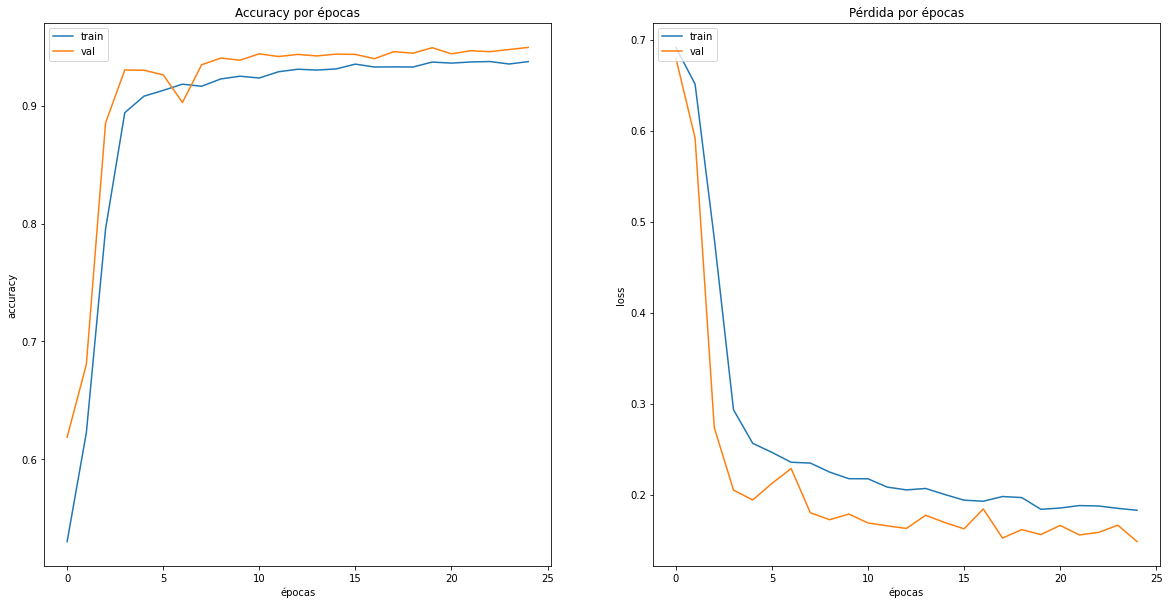

In [30]:
plt.figure(figsize=(20, 10))

# Graficamos la evolución del accuracy
plt.subplot(1, 2, 1)
plt.title('Accuracy por épocas')
plt.ylabel('accuracy')
plt.xlabel('épocas')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')

# Graficamos la evolución de la función de pérdida
plt.subplot(1, 2, 2)
plt.title('Pérdida por épocas')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Si bien vemos que el *accuracy* es similar al del modelo 2, su comportamiento es mucho más estable y podemos presupuestar que su rendimiento debería más o menos mantenerse en el set de test, lo cual vemos a continuación:

In [31]:
performance = model_3.evaluate(X_test, y_test)
print(performance)

259/259 [==============================] - 3s 11ms/step - loss: 0.1333 - accuracy: 0.9554
[0.1332593560218811, 0.9553701281547546]


Obtenemos un rendimiento ligeramente mejor en *accuracy* y una pérdida muy baja en comparación a los otros 2 modelos, por lo que podríamos afirmar que se trata del mejor modelo hasta ahora.